### Bio Clustering (Word2Vec and Kmeans Clustering)

In [155]:
import pandas as pd
import numpy as np
from time import time
import re
import os
import nltk
import gensim.models.word2vec as w2v

nltk.download("punkt")
nltk.download("stopwords")

from nltk.corpus import stopwords

from nltk import word_tokenize
from nltk.stem import PorterStemmer

import multiprocessing

import seaborn as sns
import gensim.models.word2vec as w2v
import matplotlib.pyplot as plt
import sklearn.manifold

from  sklearn.cluster import KMeans

[nltk_data] Downloading package punkt to /home/paraz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/paraz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Reading file and creating dataframe

In [2]:
with open("_data/unlabled/bio_1501598612.022413.txt") as f:
    all_data = f.read().split('\n')

In [3]:
def clean_sentence(raw):
    noise_words = []
    stop_words = list(set(stopwords.words('english')))
    URL_REGEX = r"""(?i)\b((?:[a-z][\w-]+:(?:/{1,3}|[a-z0-9%])|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?<>""'']))"""
    raw = re.sub(URL_REGEX, '', raw, flags=re.MULTILINE)
    for n in noise_words:
        clean = raw.replace(n, " ")
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    stop_words = list(set(stopwords.words('english')))
    words = [w for w in words if w not in stop_words]
    return " ".join(words)

In [4]:
df = pd.DataFrame(all_data, columns=['bio'])
df.replace('', np.nan, inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.tail()

df = pd.DataFrame(df['bio'].apply(clean_sentence))
df.drop_duplicates(inplace=True)
df.count()

bio    13364
dtype: int64

#### Data Details

In [5]:
df.describe()

,bio
count,13364
unique,13364
top,NATIONAL JOINT GENERAL SECRETARY ORGANISATION ...
freq,1


In [6]:
df['word_freq'] = df['bio'].apply(lambda x: len(x.split()))

#### Average sentence length

In [7]:
df['word_freq'].mean()

10.4408111343909

### Word2Vec Feature Extraction

In [8]:
def sentence_to_wordlist(text, stem=True):
    """ Tokenize text and stem words removing punctuation """
    tokens = word_tokenize(text.lower())
    return tokens

In [9]:
sentences = []
for raw_sentence in df['bio']:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [10]:
sentences[909]

['an',
 'online',
 'master',
 'information',
 'data',
 'science',
 'mids',
 'degree',
 'uc',
 'berkeley',
 'school',
 'information',
 'learn']

In [11]:
token_count = sum([len(sentence) for sentence in sentences])
print("The corpus contains {0:,} tokens".format(token_count))

The corpus contains 139,560 tokens


**Word2Vec model**



In [12]:
# Dimensionality of the resulting word vectors.
# more dimensions mean more training them, but more generalized
num_features = 300
# Minimum word count threshold.
min_word_count = 3
# Number of threads to run in parallel.
num_workers = multiprocessing.cpu_count()
# Context window length.
context_size = 7
# Downsample setting for frequent words.
#rate 0 and 1e-5 
#how often to use
downsampling = 1e-3
# Seed for the RNG, to make the results reproducible.
seed = 1

In [13]:
t0 = time()
bio_vec = w2v.Word2Vec(
    sentences,
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling,
    iter = 10
)

print("Train Time:", time()-t0)

Train Time: 23.74689817428589


In [14]:
if not os.path.exists("_data/trained"):
    os.makedirs("_data/trained")

bio_vec.save(os.path.join("_data/trained", "bioVectors.w2v"))

In [15]:
bio_vec.most_similar_cosmul("machine")

[('deep', 0.9731927514076233),
 ('machinelearning', 0.966892659664154),
 ('ai', 0.9650992155075073),
 ('algorithms', 0.9612061977386475),
 ('learning', 0.9599374532699585),
 ('deeplearning', 0.9597312808036804),
 ('brain', 0.958436131477356),
 ('computational', 0.9539759159088135),
 ('rstats', 0.9537715911865234),
 ('nlp', 0.9535612463951111)]

In [16]:
print("Vocab Size:", len(bio_vec.wv.vocab.keys()))

Vocab Size: 6339


### Visualization and word-D-reduction

In [27]:
t1 = time()
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
all_word_vectors_matrix = bio_vec.wv.syn0
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)
print("Dimension reduction Time:", time()-t1)

Dimension reduction Time: 126.68109440803528


In [28]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[bio_vec.wv.vocab[word].index])
            for word in bio_vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

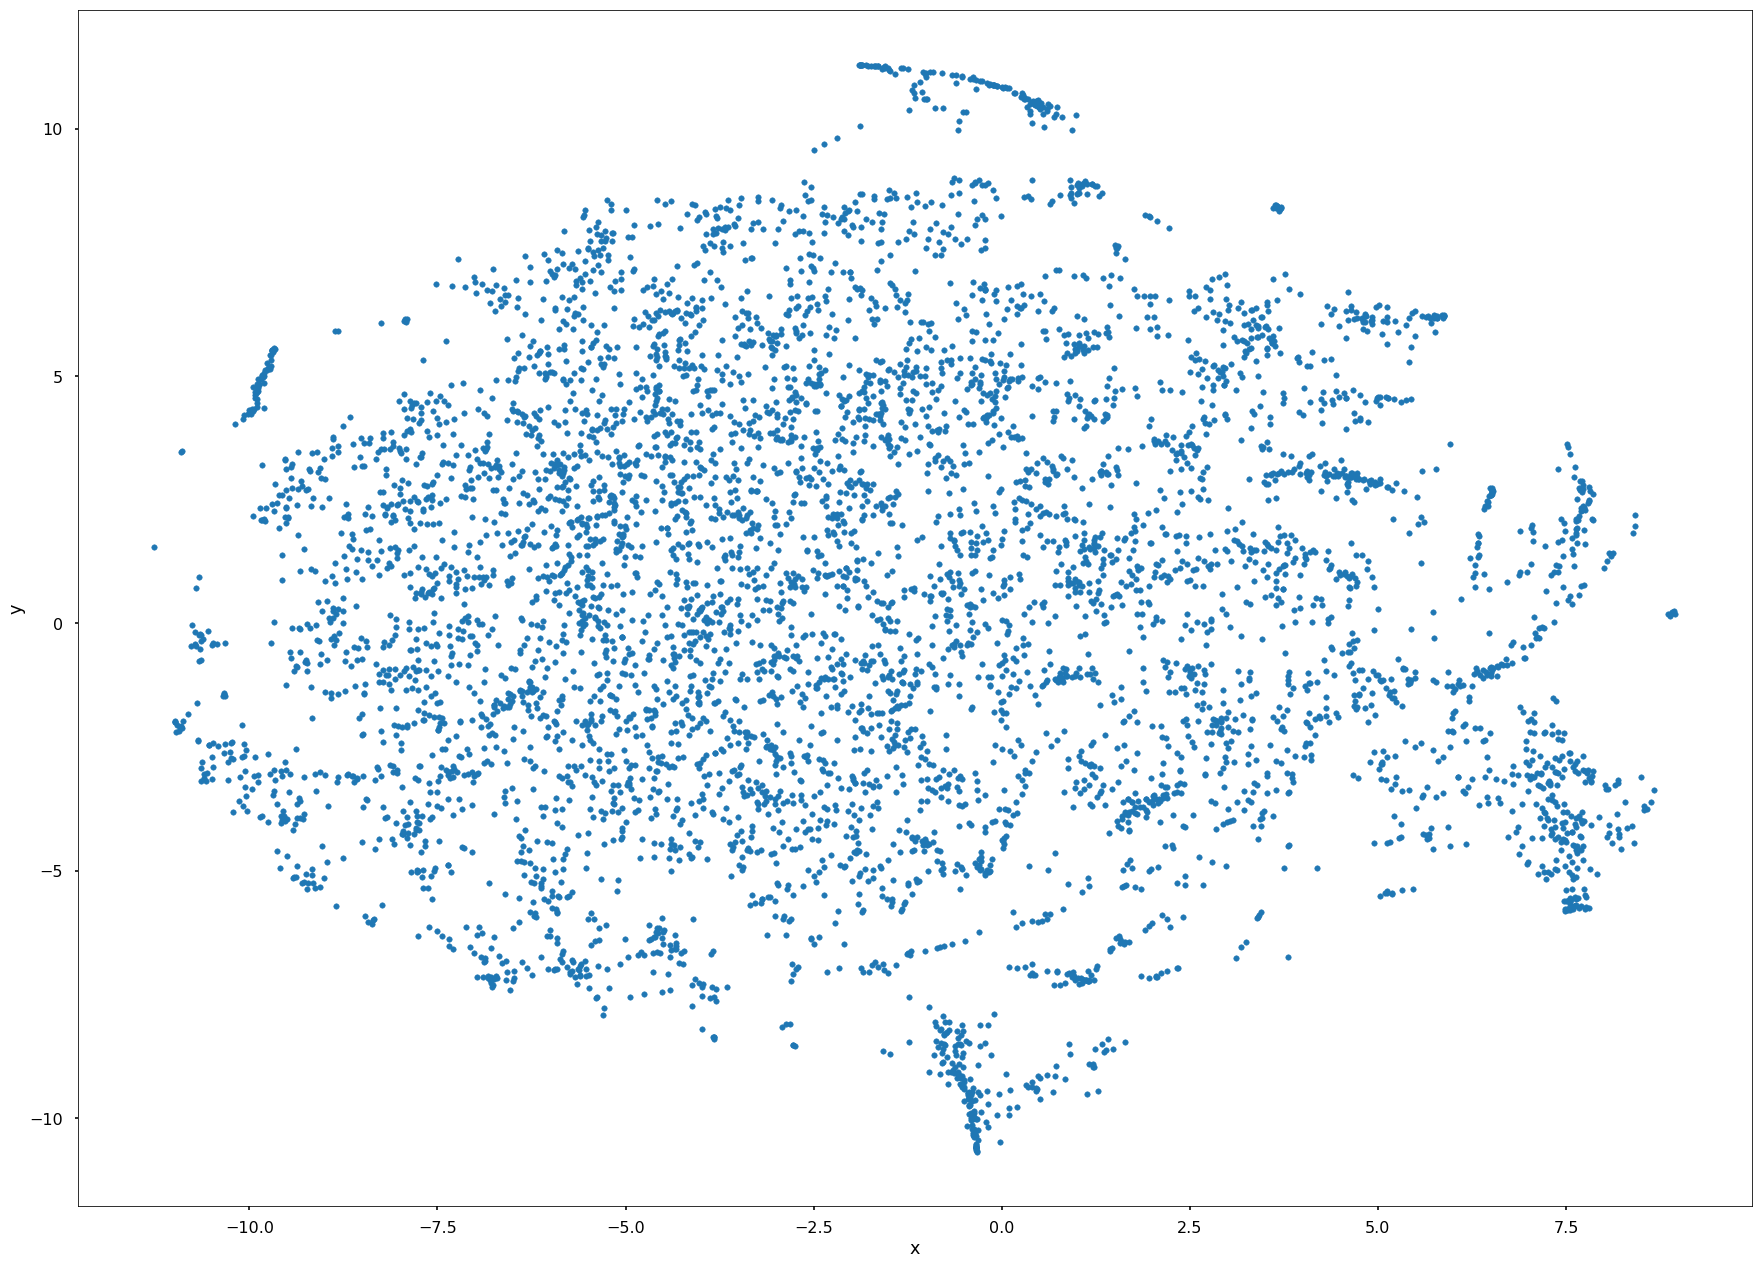

In [29]:
sns.set_context("poster")
points.plot.scatter("x", "y", s=30, figsize=(30, 22))
plt.show()

In [30]:
def plot_region(x_bounds, y_bounds):
    try:
        slice = points[
            (x_bounds[0] <= points.x) &
            (points.x <= x_bounds[1]) & 
            (y_bounds[0] <= points.y) &
            (points.y <= y_bounds[1])
        ]

        ax = slice.plot.scatter("x", "y", s=90, figsize=(10, 8))
        for i, point in slice.iterrows():
            ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)
    except:
        print("No word in this region")

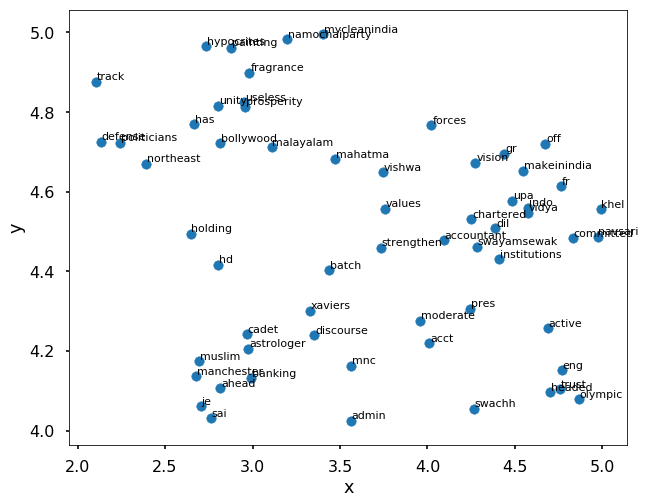

In [37]:
plot_region(x_bounds=(2, 5), y_bounds=(4, 5))

plt.show()

### Sentence Embedding and Clustering

In [70]:
def preprocess_text(raw):
    noise_words = []
    stop_words = list(set(stopwords.words('english')))
    URL_REGEX = r"""(?i)\b((?:[a-z][\w-]+:(?:/{1,3}|[a-z0-9%])|www\d{0,3}[.]|
                [a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+
                (?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?<>""'']))"""
    raw = re.sub(URL_REGEX, '', raw, flags=re.MULTILINE)
    for n in noise_words:
        clean = raw.replace(n, " ")
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    stop_words = list(set(stopwords.words('english')))
    words = [w for w in words if w not in stop_words]
    tokens = word_tokenize(raw.lower())
    return tokens

In [99]:
def embed_sentences(s):
    sample_text_tokens = preprocess_text(s)
    word_vectors = np.array([]).reshape(0, 300)
    for t in sample_text_tokens:
        if t in bio_vec.wv.vocab.keys():
            word_vectors = np.vstack([word_vectors, bio_vec[t]])
    if len(word_vectors):
        return np.array((np.max(word_vectors), np.min(word_vectors)))
    else:
        return [0, 0]

In [304]:
sentence_vectors = np.array([]).reshape(0, 2)

for index, row in df.iterrows():
    sentence_vectors = np.vstack([sentence_vectors, embed_sentences(row['bio'])])

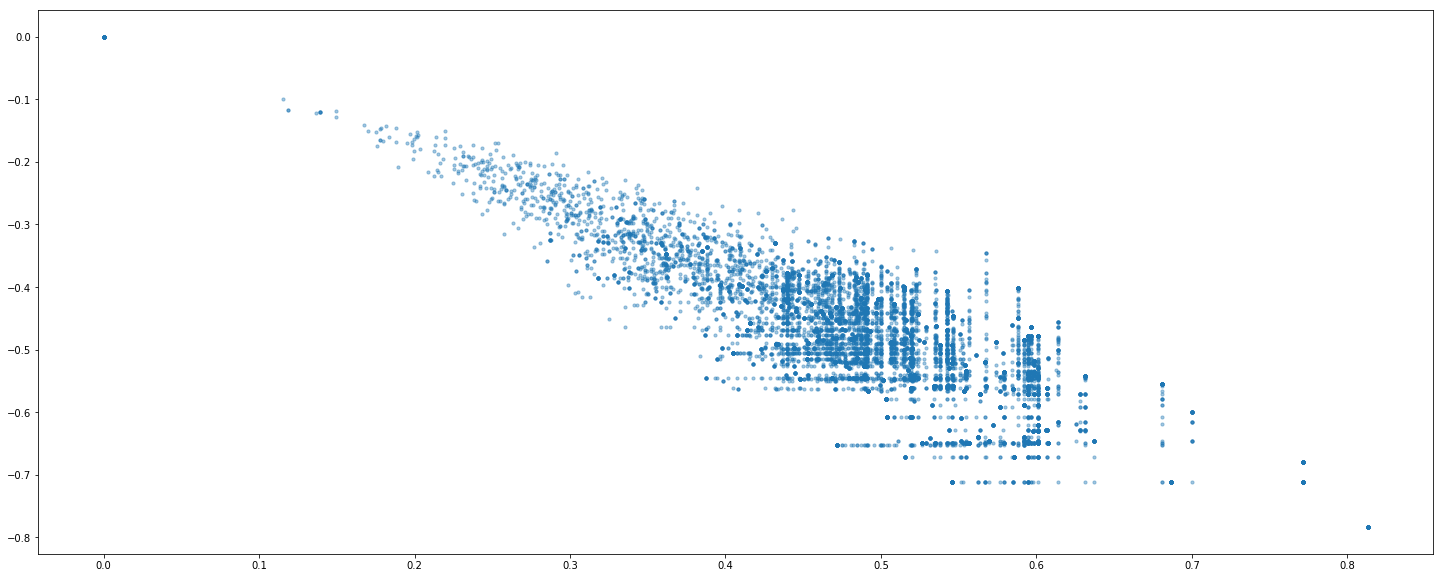

In [150]:
plt.figure(figsize=(25, 10))
plt.scatter([i[0] for i in sentence_vectors], [i[1] for i in sentence_vectors], s=10, alpha=0.4)
plt.show()

In [302]:
def kmeans(data, clus):
    km = KMeans(n_clusters=clus, init='k-means++', max_iter=1000, n_init=1,
                    verbose=False)

    print("Clustering sparse data with %s" % km)
    t0 = time()
    km.fit(data)
    print("done in %0.3fs" % (time() - t0))

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1


    plt.figure(figsize=(25, 10))
    plt.scatter(data[:, 0], data[:, 1], s=10, alpha=0.4)

    # Plot the centroids as a white X
    centroids = km.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=90, linewidths=1,
                color='r')
    plt.title('K-means clustering')
    plt.show()
    return km

Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=5, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=False)
done in 0.056s


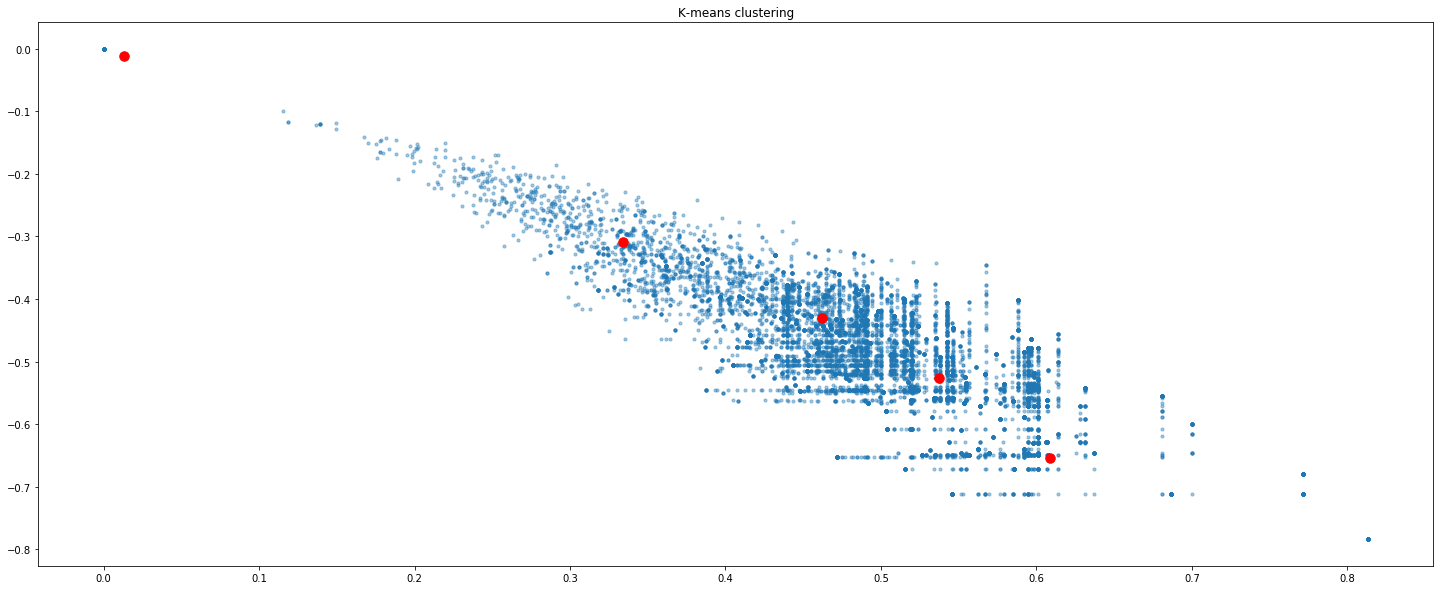

In [305]:
kmean_w2v = kmeans(sentence_vectors, 5)

In [306]:
clusters = {i: df['bio'][np.where(kmean_w2v.labels_ == i)[0]] for i in range(kmean_w2v.n_clusters)}

In [307]:
clusters[0]

0        Ph D student StanfordCVGL Computer Vision I li...
2        BTech CSE Guru Nanak Dev University Amritsar P...
5                        Contact pydatadelhi gmail dot com
10                     Follow Youtube SwastikaSS Subscribe
12       Creative singer songwriter producer Merch Mana...
14                               Computer Science Engineer
15       Pathfinder Progressive Innovator Designer Stat...
16        Tech Enthusiast Learner App Developer statusbrew
17                                       Android Developer
18       Tech enthusiast Game Development Ethical Hacki...
22       Jack successful tech entrepreneur passionate A...
23       host dataleaders io founder TryResonateAI fun ...
29                            Product Developer statusbrew
34       UX Designer Thinker Reviewer Movies TV shows C...
43       Complete social media management platform disc...
45       Sneak peak global team Statusbrew India Japan ...
47       Business Eco Fin Politics Views personal RTs e.

### Word2Vec + TfIDF

In [226]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [257]:
vectorizer = TfidfVectorizer(max_df=0.5, max_features=300,
                                 min_df=2, stop_words='english',
                                 use_idf=True)

TfX = vectorizer.fit_transform(df['bio'])

In [258]:
feature_names = vectorizer.get_feature_names()
def get_tfidf_weight(doc):
    feature_index =TfX[doc,:].nonzero()[1]
    tfidf_scores = zip(feature_index, [TfX[doc, x] for x in feature_index])
    result = {}
    for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
        result[w] = s
    return result

In [260]:
get_tfidf_weight(10)

{'follow': 0.6167500033767237, 'youtube': 0.78715909023196273}

In [322]:
def embed_sentences_tfidf_weight(s, doc):
    sample_text_tokens = preprocess_text(s)
    word_vectors = np.array([]).reshape(0, 300)
    word_weights = get_tfidf_weight(doc)
    vector_weight = 0
    for t in sample_text_tokens:
        if t in word_weights:
            vector_weight = word_weights[t]
        if t in bio_vec.wv.vocab.keys():
            word_vectors = np.vstack([word_vectors, np.add(vector_weight, bio_vec[t])])
    if len(word_vectors):
        return np.array((np.max(word_vectors), np.min(word_vectors)))
    else:
        return [0, 0]

In [323]:
sentence_vectors_tf = np.array([]).reshape(0, 2)

i = 0
for index, row in df.iterrows():
    sentence_vectors_tf = np.vstack([sentence_vectors, embed_sentences_tfidf_weight(row['bio'], i)])
    i+=1

Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=5, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=False)
done in 0.066s


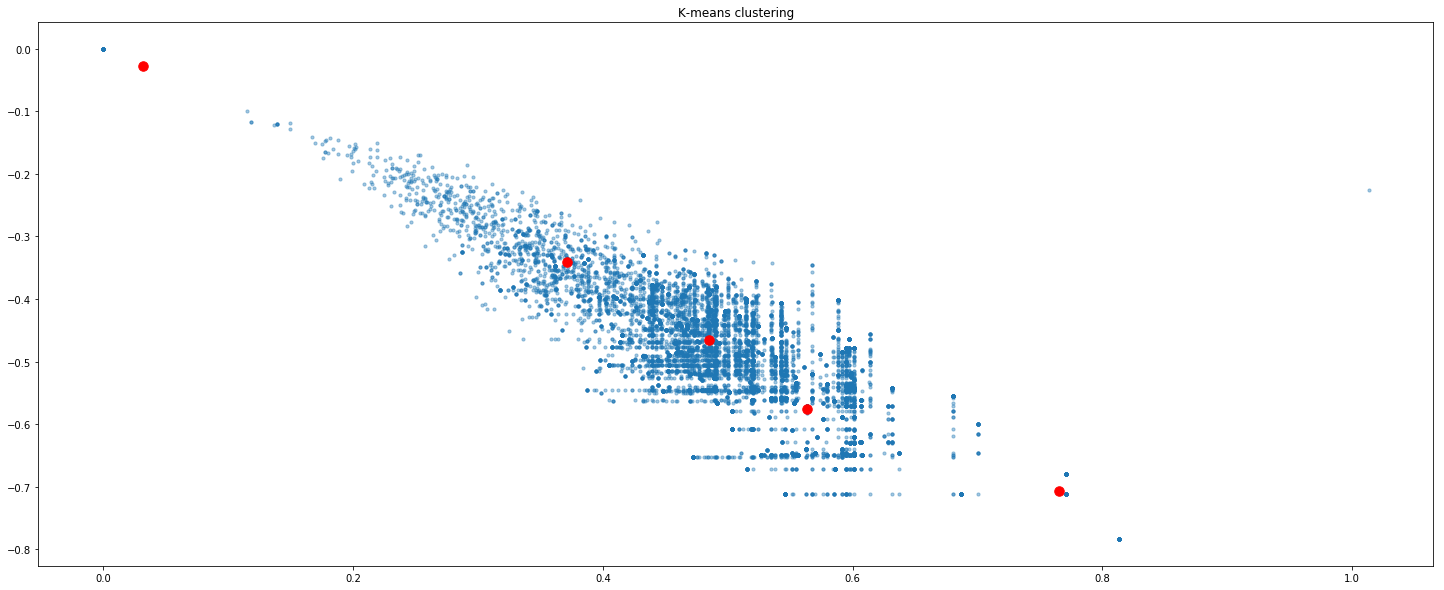

In [324]:
kmean_tfidf_w2v = kmeans(sentence_vectors_tf, 5)

In [318]:
clusters_tfidf = {i: df['bio'][np.where(kmean_tfidf_w2v.labels_ == i)[0]] for i in range(kmean_tfidf_w2v.n_clusters)}

In [319]:
clusters_tfidf[0]

0        Ph D student StanfordCVGL Computer Vision I li...
5                        Contact pydatadelhi gmail dot com
8                               I Singer Dreamer Patriotic
9          Interested Music Tech Scifi Future Humour Books
11         Costume Design graduate Nicolas Cage enthusiast
12       Creative singer songwriter producer Merch Mana...
14                               Computer Science Engineer
15       Pathfinder Progressive Innovator Designer Stat...
16        Tech Enthusiast Learner App Developer statusbrew
17                                       Android Developer
18       Tech enthusiast Game Development Ethical Hacki...
19                                      Free Vedic thinker
20       Design things statusbrew Reader Listener Daydr...
21       Get remote job anywhere remote jobs Feed remot...
23       host dataleaders io founder TryResonateAI fun ...
25                               Coding Freak Entrepreneur
26       Tweet Random things Reader Listener Junkie Gam.